#Training model

In [52]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import tempfile
import json

Preprocess

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 10

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy" ,test_acc)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.8870
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3028 - sparse_categorical_accuracy: 0.8924
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2934 - sparse_categorical_accuracy: 0.8953
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2875 - sparse_categorical_accuracy: 0.8979
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.9003
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.9020
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.9022
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2679 - sparse_categorical_accuracy: 0.9039
Epoch 9/10
1875/1875 [==========

#Saving model

In [12]:
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 96
drwxr-xr-x 2 root root  4096 Oct 12 04:25 assets
-rw-r--r-- 1 root root  8204 Oct 12 04:25 keras_metadata.pb
-rw-r--r-- 1 root root 74719 Oct 12 04:25 saved_model.pb
drwxr-xr-x 2 root root  4096 Oct 12 04:25 variables


#TF serving

In [56]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  98100      0 --:--:-- --:--:-- --:--:--   99k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/comp

In [57]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.6.0).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [58]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [59]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 5 in a separate thread.


In [60]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})

In [62]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

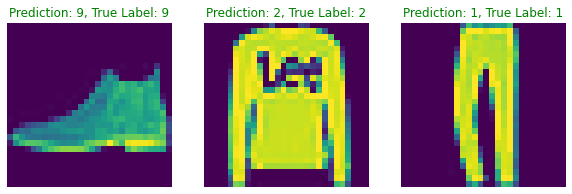

In [66]:
plt.figure(figsize=(10,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[i].reshape(28,28))
    plt.axis('off')
    plt.title('Prediction: {}, True Label: {}'.format(np.argmax(predictions[i]), test_labels[i]), color=color)
    
plt.show()